# Multi-layer Perceptron(MLP)

## Install Library & requirements

In [ ]:
!pwd

In [1]:
import os
import sys
from datetime import datetime

drive_project_root = "/home/jmj3047/mj_MLP_prac"
sys.path.append(drive_project_root)


In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim

from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [3]:
#!pwd
data_root = os.path.join(os.getcwd(), 'data')

#preprocessing & 데이터 셋 정의
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]) #mean, std
    ]
)

fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform=transform)


## DataLoader 정의

In [4]:
from torch.utils.data import random_split
from data_utils import dataset_split

In [5]:
datasets= dataset_split(fashion_mnist_dataset, split=[0.9,0.1])

train_dataset = datasets['train']
val_dataset = datasets['val']

train_batch_size = 100
val_batch_size = 10

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = train_batch_size, shuffle=True, num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = val_batch_size, shuffle=True, num_workers=1
)

In [6]:
for sample_batch in train_dataloader:
    print(sample_batch[0].shape, sample_batch[1].shape)
    break

#torch.Size([100, 1, 28, 28]) batchsize, channel, width, height

torch.Size([100, 1, 28, 28]) torch.Size([100])


## 모델(Multi-Layer Perceptron) (MLP) 정의
## 모델 MLPWithDropout 정의

In [7]:
import torch. nn.functional as F

In [10]:
#Define Model

class MLP(nn.Module):
    def __init__(self, in_dim=int, h1_dim = int, h2_dim = int, out_dim = int):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, out_dim)
        self.relu = F.relu #activation 함수 정의

        pass

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        out = self.linear3(x)
        out = F.sigmoid(out) #binary classification은 softmax로 사용
        return out



class MLPWithDropout(MLP):
    def __init__(self, in_dim: int, h1_dim: int, h2_dim: int, out_dim: int, dropout_prob: float):
        super().__init__(in_dim, h1_dim, h2_dim, out_dim)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)
    
    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.dropout1(x)
        x = self.relu(self.linear2(x))
        x = self.dropout2(x)
        out = self.linear3(x)
        # out = F.softmax(out)
        return out


## 모델 선언 및 손실함수, 최적화(Optimizer) 정의, Tensorboard Logger 정의

In [16]:
#define model
# model = MLP(28*28, 128, 64, 10)
model = MLPWithDropout(28*28, 128,64,10, dropout_prob=0.3)
model_name = type(model).__name__
print(model_name)

#define loss
loss_function = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
max_epoch = 10

#define tensorboard logger
log_dir = f"runs/{datetime.now()}-{model_name}"
writer = SummaryWriter(log_dir=log_dir)
# writer = SummaryWriter()
log_interval =100

# set save model path
log_model_path = os.path.join(log_dir, "models")
os.makedirs(log_model_path, exist_ok=True)

MLPWithDropout


## Early Stopping callback Object Class 정의

In [17]:
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.ckpt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None: #loss가 최소화 됐을때 save_checkpoint를 저장함
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta: #모델 성능이 더이상 개선되지 않는다 했을 때 early stopping이 됨
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: #개선이 안됐다고 바로 하는게 아니라 조금 기다렸다가 stop함
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        filename = self.path.split('/')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f"val_loss-{val_loss}-{filename}")) #어떤 score에서 멈췄는지가 중요하기 때문에 그걸 print해줌
        self.val_loss_min = val_loss

In [18]:
%load_ext tensorboard
%tensorboard --logdir runs/ #여기다가 log를 쌓을거고 거기 있는걸 plot해달라는 의미

#define EarlyStopping
early_stopper = EarlyStopping(
    patience=3, verbose=True, path = os.path.join(log_model_path, "model.ckpt")
)

#do train with validation
train_step = 0
for epoch in range(1, max_epoch+1):
    #validation step
    with torch.no_grad(): # optimizer가 업데이트 하면 안됨
        val_loss = 0.0
        val_corrects = 0
        model.eval()

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position=0, leave=True, desc = 'validation')
        ):
            #forward
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            
            #loss & acc
            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0] #이게 batch size. batch size만큼 평균을 내겠다는 뜻
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]
        
        #valid step logging
        val_epoch_loss = val_loss / len(val_dataloader)
        val_epoch_acc = val_corrects/len(val_dataloader)
        print(
            f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}" 
        )
        writer.add_scalar("Loss/val", val_epoch_loss, train_step)
        writer.add_scalar("Acc/val", val_epoch_acc, train_step)
        writer.add_images("Images/val", val_images, train_step)

        # check early stopping point & save model if model reached the best performance
        early_stopper(val_epoch_loss, model)
        if early_stopper.early_stop:
            break
        
        #train step
        current_loss = 0
        current_corrects = 0
        model
                



    #train step
    for batch_idx, (images, labels) in enumerate(
         tqdm(train_dataloader, position=0, leave=True, desc = 'train')
    ):
        current_loss = 0.0
        current_corrects = 0

        #get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        # print(outputs)
        # print(preds)
        
        #get loss
        loss = loss_function(outputs, labels)


        ###### 여기까지가 forward ###

        #Backpropagation

        #optimitizer 초기화(zero화)
        optimizer.zero_grad()

        #perform backward pass
        loss.backward()

        #perfrom optimization
        optimizer.step()

        current_loss +=loss.item()
        current_corrects += torch.sum(preds == labels.data)

        if train_step % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = current_corrects/log_interval
            print(
                f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}" 
            )
            writer.add_scalar("Loss/train", train_step)
            writer.add_scalar("Acc/train", train_step)
            writer.add_images("Images/train", images, train_step)
            writer.add_graph(model, images)
            current_loss = 0
            current_corrects = 0

        train_step += 1



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 31906), started 4:15:33 ago. (Use '!kill 31906' to kill it.)

train:   0%|          | 0/540 [00:00<?, ?it/s]

1 epoch, 0 step: val_loss: 0.23035308718681335, val_acc: 0.09666651487350464
Validation loss decreased (inf --> 0.230353).  Saving model ...
0: train_loss: 0.023103275299072266, train_acc: 0.10000000149011612


train:  19%|█▊        | 101/540 [00:02<00:13, 31.79it/s]

100: train_loss: 0.006068005561828614, train_acc: 0.7599999904632568


train:  38%|███▊      | 205/540 [00:05<00:09, 34.20it/s]

200: train_loss: 0.005702927112579346, train_acc: 0.7599999904632568


train:  56%|█████▌    | 301/540 [00:08<00:08, 29.10it/s]

300: train_loss: 0.005056851506233215, train_acc: 0.8199999928474426


train:  75%|███████▌  | 405/540 [00:10<00:03, 38.50it/s]

400: train_loss: 0.004364617168903351, train_acc: 0.8399999737739563


train:  93%|█████████▎| 501/540 [00:13<00:01, 31.75it/s]

500: train_loss: 0.0035428255796432495, train_acc: 0.8999999761581421


train:   0%|          | 0/540 [00:00<?, ?it/s]

2 epoch, 540 step: val_loss: 0.04364863038063049, val_acc: 0.8376650214195251
Validation loss decreased (0.230353 --> 0.043649).  Saving model ...


train:  12%|█▏        | 65/540 [00:01<00:14, 33.66it/s]

600: train_loss: 0.002477666437625885, train_acc: 0.8999999761581421


train:  30%|███       | 163/540 [00:04<00:24, 15.29it/s]

700: train_loss: 0.003697135150432587, train_acc: 0.8500000238418579


train:  48%|████▊     | 261/540 [00:07<00:08, 31.38it/s]

800: train_loss: 0.0038509243726730347, train_acc: 0.8500000238418579


train:  68%|██████▊   | 365/540 [00:10<00:04, 36.34it/s]

900: train_loss: 0.0035421961545944215, train_acc: 0.8700000047683716


train:  86%|████████▌ | 465/540 [00:13<00:04, 16.21it/s]

1000: train_loss: 0.003900415301322937, train_acc: 0.8799999952316284


train:   0%|          | 0/540 [00:00<?, ?it/s]

3 epoch, 1080 step: val_loss: 0.037912704050540924, val_acc: 0.8609982132911682
Validation loss decreased (0.043649 --> 0.037913).  Saving model ...


train:   4%|▍         | 21/540 [00:00<00:18, 27.95it/s]

1100: train_loss: 0.005417489409446716, train_acc: 0.8100000023841858


train:  21%|██▏       | 116/540 [00:03<00:11, 37.54it/s]

1200: train_loss: 0.005331524014472962, train_acc: 0.7699999809265137


train:  41%|████      | 221/540 [00:06<00:09, 34.08it/s]

1300: train_loss: 0.0028566533327102663, train_acc: 0.8899999856948853


train:  60%|█████▉    | 323/540 [00:08<00:06, 34.98it/s]

1400: train_loss: 0.0031241199374198916, train_acc: 0.9200000166893005


train:  78%|███████▊  | 423/540 [00:11<00:03, 33.58it/s]

1500: train_loss: 0.0028911587595939637, train_acc: 0.8999999761581421


train:  96%|█████████▋| 521/540 [00:14<00:00, 31.79it/s]

1600: train_loss: 0.0030061662197113036, train_acc: 0.8899999856948853


train:   0%|          | 0/540 [00:00<?, ?it/s]

4 epoch, 1620 step: val_loss: 0.03575781360268593, val_acc: 0.8681640625
Validation loss decreased (0.037913 --> 0.035758).  Saving model ...


train:  16%|█▌        | 84/540 [00:02<00:13, 32.96it/s]

1700: train_loss: 0.0021404443681240083, train_acc: 0.9100000262260437


train:  34%|███▍      | 185/540 [00:05<00:09, 36.02it/s]

1800: train_loss: 0.002276214361190796, train_acc: 0.9200000166893005


train:  52%|█████▏    | 281/540 [00:07<00:09, 28.12it/s]

1900: train_loss: 0.004952814877033234, train_acc: 0.800000011920929


train:  71%|███████   | 382/540 [00:10<00:05, 30.41it/s]

2000: train_loss: 0.003769998252391815, train_acc: 0.8399999737739563


train:  89%|████████▉ | 482/540 [00:13<00:01, 34.84it/s]

2100: train_loss: 0.0039564380049705505, train_acc: 0.8299999833106995


train:   0%|          | 0/540 [00:00<?, ?it/s]

5 epoch, 2160 step: val_loss: 0.03462181240320206, val_acc: 0.8739975094795227
Validation loss decreased (0.035758 --> 0.034622).  Saving model ...


train:   8%|▊         | 41/540 [00:01<00:16, 30.86it/s]

2200: train_loss: 0.003867652416229248, train_acc: 0.8999999761581421


train:  27%|██▋       | 144/540 [00:04<00:11, 33.28it/s]

2300: train_loss: 0.0024657072126865387, train_acc: 0.8799999952316284


train:  46%|████▌     | 246/540 [00:06<00:07, 36.81it/s]

2400: train_loss: 0.004069816470146179, train_acc: 0.8600000143051147


train:  63%|██████▎   | 341/540 [00:09<00:05, 33.24it/s]

2500: train_loss: 0.0032155823707580564, train_acc: 0.8399999737739563


train:  82%|████████▏ | 445/540 [00:12<00:02, 33.55it/s]

2600: train_loss: 0.0023466287553310394, train_acc: 0.9100000262260437


train:   0%|          | 0/540 [00:00<?, ?it/s]

6 epoch, 2700 step: val_loss: 0.0352231003344059, val_acc: 0.8703309893608093
EarlyStopping counter: 1 out of 3
2700: train_loss: 0.0030283153057098387, train_acc: 0.9100000262260437


train:  19%|█▉        | 102/540 [00:03<00:30, 14.38it/s]

2800: train_loss: 0.002282608151435852, train_acc: 0.8899999856948853


train:  38%|███▊      | 205/540 [00:06<00:09, 33.79it/s]

2900: train_loss: 0.0016799382865428925, train_acc: 0.9399999976158142


train:  56%|█████▌    | 303/540 [00:08<00:07, 33.64it/s]

3000: train_loss: 0.003069417178630829, train_acc: 0.8700000047683716


train:  74%|███████▍  | 401/540 [00:11<00:04, 33.45it/s]

3100: train_loss: 0.0012197183817625045, train_acc: 0.9700000286102295


train:  93%|█████████▎| 504/540 [00:14<00:01, 31.13it/s]

3200: train_loss: 0.0023747621476650238, train_acc: 0.9200000166893005


train:   0%|          | 0/540 [00:00<?, ?it/s]

7 epoch, 3240 step: val_loss: 0.03366972133517265, val_acc: 0.8774977326393127
Validation loss decreased (0.034622 --> 0.033670).  Saving model ...


train:  12%|█▏        | 65/540 [00:01<00:13, 34.67it/s]

3300: train_loss: 0.002598412334918976, train_acc: 0.9100000262260437


train:  30%|███       | 163/540 [00:04<00:24, 15.69it/s]

3400: train_loss: 0.003988162279129028, train_acc: 0.8600000143051147


train:  49%|████▊     | 263/540 [00:07<00:08, 32.30it/s]

3500: train_loss: 0.0036907505989074705, train_acc: 0.8399999737739563


train:  67%|██████▋   | 364/540 [00:10<00:05, 34.33it/s]

3600: train_loss: 0.0031452548503875734, train_acc: 0.8899999856948853


train:  86%|████████▌ | 462/540 [00:12<00:02, 33.20it/s]

3700: train_loss: 0.0035971441864967348, train_acc: 0.8600000143051147


train:   0%|          | 0/540 [00:00<?, ?it/s]

8 epoch, 3780 step: val_loss: 0.0364859402179718, val_acc: 0.8671644926071167
EarlyStopping counter: 1 out of 3


train:   4%|▍         | 21/540 [00:00<00:18, 28.07it/s]

3800: train_loss: 0.0028773733973503114, train_acc: 0.8700000047683716


train:  23%|██▎       | 122/540 [00:03<00:12, 33.03it/s]

3900: train_loss: 0.0030748343467712404, train_acc: 0.8899999856948853


train:  41%|████      | 222/540 [00:06<00:10, 31.55it/s]

4000: train_loss: 0.001909531056880951, train_acc: 0.9300000071525574


train:  60%|██████    | 325/540 [00:08<00:06, 33.21it/s]

4100: train_loss: 0.0016524963080883025, train_acc: 0.9300000071525574


train:  78%|███████▊  | 421/540 [00:11<00:03, 34.95it/s]

4200: train_loss: 0.003104139268398285, train_acc: 0.8999999761581421


train:  96%|█████████▋| 521/540 [00:14<00:00, 32.32it/s]

4300: train_loss: 0.0026103359460830687, train_acc: 0.9200000166893005


train:   0%|          | 0/540 [00:00<?, ?it/s]

9 epoch, 4320 step: val_loss: 0.035119447857141495, val_acc: 0.8749983906745911
EarlyStopping counter: 2 out of 3


train:  16%|█▌        | 85/540 [00:02<00:13, 34.07it/s]

4400: train_loss: 0.002218441069126129, train_acc: 0.9300000071525574


train:  34%|███▍      | 184/540 [00:05<00:10, 35.04it/s]

4500: train_loss: 0.0022922100126743315, train_acc: 0.949999988079071


train:  52%|█████▏    | 283/540 [00:07<00:08, 31.73it/s]

4600: train_loss: 0.003106357753276825, train_acc: 0.8799999952316284


train:  71%|███████   | 383/540 [00:10<00:04, 32.96it/s]

4700: train_loss: 0.0022266386449337006, train_acc: 0.9100000262260437


train:  89%|████████▉ | 481/540 [00:13<00:02, 22.63it/s]

4800: train_loss: 0.002425556629896164, train_acc: 0.8999999761581421


validation: 100%|██████████| 600/600 [00:02<00:00, 266.53it/s]

10 epoch, 4860 step: val_loss: 0.03368304297327995, val_acc: 0.8746644854545593
EarlyStopping counter: 3 out of 3


In [ ]:
# save model
# os.makedirs("./logs/models", exist_ok=True)
# torch.save(model, os.path.join(log_model_path, "model.ckpt"))

In [19]:
log_model_path

'runs/2022-04-28 15:31:53.026827-MLPWithDropout/models'

In [20]:
# load model
loaded_model = torch.load(os.path.join(log_model_path, "val_loss-0.03366972133517265-model.ckpt"))
loaded_model.eval()
print(loaded_model)

MLPWithDropout(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
)


In [21]:
def softmax(x, axis=0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis = axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [22]:
test_batch_size = 100
test_dataset = FashionMNIST(data_root, download=True, train=False, transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list = []


for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc="testing")):
    #forward
    test_outputs = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = softmax(test_outputs.detach().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().numpy())
    test_labels_list.extend(test_preds.detach().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"acc: {np.mean(test_preds_list==test_labels_list)*100}%")

testing: 100%|██████████| 100/100 [00:01<00:00, 71.17it/s]

acc: 100.0%


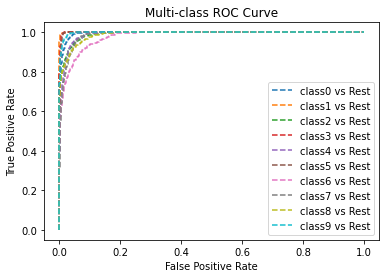

0.993464765376935


In [23]:
#ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr={}
tpr={}
thresh={}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:,i], pos_label=i)

#print(fpr)

#plot
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle = '--', label=f"class{i} vs Rest")
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "best")
plt.show()

print(roc_auc_score(test_labels_list, test_outputs_list, multi_class='ovo', average='macro'))